# 2 Data Wrangling<a id='2_Data_wrangling'></a>

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Data wrangling](#2_Data_wrangling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
    * [2.2.1 Recap Of Data Science Problem](#2.2.1_Recap_Of_Data_Science_Problem)
    * [2.2.2 Objective of Data Wrangling](#2.2.2_Objective_of_Data_Wrangling)
  * [2.3 Imports](#2.3_Imports)
  * [2.4 Explore The Data](#2.4_Explore_The_Data)
    * [2.4.1 Image Counts](#2.4.1_Image_Counts)
    * [2.4.2 First Image](#2.4.2_First_Image)
    * [2.4.3 Image Consistency](#2.4.3_Image_Consistency)
      * [2.4.3.1 First Image Consistency](#2.4.3.1_First_Image_Consistency)
        * [2.4.3.1.1 Single Image Check for COVID](#2.4.3.1.1_Single_Image_Check_for_COVID)
        * [2.4.3.1.2 Single Image Check for NORMAL](#2.4.3.1.1_Single_Image_Check_for_NORMAL)
        * [2.4.3.1.3 Single Image Check for VP](#2.4.3.1.1_Single_Image_Check_for_VP)
      * [2.4.3.2 Overall Image Consistency Check](#2.4.3.2_Overall_Image_Consistency_Check)    
  * [2.5 Summary](#2.5_Summary)


## 2.2 Introduction<a id='2.2_Introduction'></a>

This step focuses on collecting the data, organizing it, and making sure it's well defined. Some data cleaning will be done at this stage.

### 2.2.1 Recap Of Data Science Problem<a id='2.2.1_Recap_Of_Data_Science_Problem'></a>

The purpose of this data science project is to classify X-ray images to diagnose COVID-19,and the focus of the project will be classifying X-ray images for other respiratory diseases. The ultimate goal of this project is to enhanced diagnostic accuracy by apply ML models, reduce the time taken for diagnosis, enable medical professionals to make quicker decisions and allocate resources more effectively


### 2.2.2 Objective of Data Wrangling<a id='2.2.2_Objective_of_Data_Wrangling'></a>

In this part of notebook, I ll try to address:
1) check image in individual folder

2) Image normalization

3) Understand the distribution of classes. Is it balanced? If not, you might need to consider techniques like oversampling, undersampling, or data augmentation.



## 2.3 Imports<a id='2.3_Imports'></a>

In [1]:
#import libs  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os

import cv2
from scipy.stats import skew, kurtosis



## 2.4 Explore The Data<a id='2.4_Explore_The_Data'></a>

### 2.4.1 Image Counts <a id='2.4.1_Image_Counts'></a>

In [2]:
def count_images(folders, valid_extensions=['.jpg', '.jpeg', '.png']):
    image_counts_dict = {}

    for folder_path in folders:
        image_count = 0
        subfolders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]  
        first_subfolder = os.path.join(folder_path, subfolders[0])

        for filename in os.listdir(first_subfolder):
            filepath = os.path.join(first_subfolder, filename)
            if os.path.isfile(filepath) and os.path.splitext(filename)[1].lower() in valid_extensions:
                image_count += 1

        image_counts_dict[folder_path] = image_count

    return image_counts_dict



In [3]:
folders = ['COVID', 'Normal', 'Lung_Opacity','Viral Pneumonia']  # Replace with your folder paths
image_counts = count_images(folders)



In [4]:
image_counts

{'COVID': 3616, 'Normal': 10192, 'Lung_Opacity': 6012, 'Viral Pneumonia': 1345}

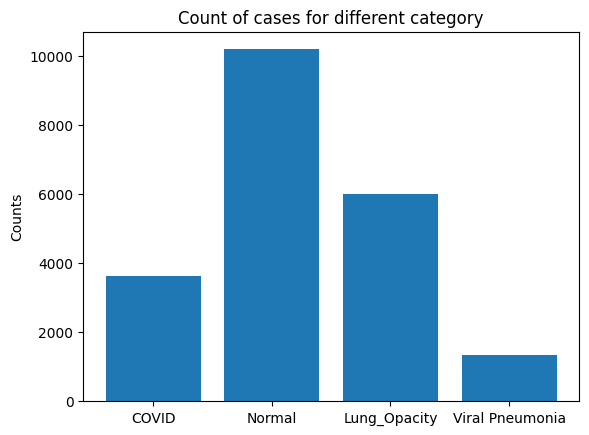

In [5]:
names = list(image_counts.keys())
values = list(image_counts.values())

plt.bar(names, values)

# Set a title and labels (optional)
plt.title("Count of cases for different category")

plt.ylabel("Counts")

# Display the plot
plt.show()

3616 images for COVID
10192 images for normal
6012 images as unknown

### 2.4.2 First Image  <a id='2.4.2_First_Image'></a>

In [6]:
def display_first_image(folders):
    # Get the list of files in the folder
    for folder_path in folders:
        subfolders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]  
        first_subfolder = os.path.join(folder_path, subfolders[0])

    # Loop through files to find the first image and display it
        for filename in os.listdir(first_subfolder):
            filepath = os.path.join(first_subfolder, filename)
            if os.path.isfile(filepath):
                try:
                    img = imageio.imread(filepath)  # Load the image
                    plt.imshow(img)  # Display the image using matplotlib
                    plt.title(os.path.basename(folder_path))
                    plt.axis('off')  # Hide axes for better visualization
                    plt.show()  # Render the image
                    break  # Exit the loop once the first image is displayed
                except:
                    pass  # Handle image read error, e.g., not an image file

        

In [7]:
folders = ['COVID', 'Normal', 'Lung_Opacity','Viral Pneumonia']

In [8]:
display_first_image(folders)

### 2.4.3 Image Consistency <a id='2.4.3_Image_Consistency'></a>

#### 2.4.3.1 Single Image Check <a id='2.4.3.1_Single_Image_Check'></a>

In [9]:
def file_path(folder_path,file_num):
    subfolders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]  
    first_subfolder = os.path.join(folder_path, subfolders[0])
    filename=os.listdir(first_subfolder)[file_num]
    file_path = os.path.join(first_subfolder, filename)
    return file_path
    

In [10]:
#analysis first image in COVID folder

def single_image_basic(file_path):
    file_extension = os.path.splitext(file_path)[1]

    # Check if the path is an actual file
    if os.path.isfile(file_path):
        is_corrupted = False
        try:
            img = cv2.imread(file_path)
             # Collect image formats, dimensions, and channels
            avg_intensity=img.mean()
            image_formats=file_extension[1:].upper()  # Assuming file format is the file extension   
            height, width = img.shape[:2]             
            image_channels=img.shape[2]    #2 for grayscale, 3 for RGB/RGBA
            noise_std_dev = np.std(img)

            pass
        except:
            is_corrupted = True
    return image_formats,image_channels,height, width,avg_intensity,noise_std_dev,is_corrupted




In [11]:
def single_image_intensity_hist(file_path, is_corrupted):
    if os.path.isfile(file_path) and is_corrupted == False:
        img = cv2.imread(file_path)
#split three channels
        blue_channel, green_channel, red_channel = cv2.split(img)
        #plot histgram for all three channels together
        plt.figure(figsize=(10, 6))
        # Plotting the histogram for the Red channel
        plt.hist(red_channel.ravel(), 256, [0, 256], color='red', alpha=0.7, label='Red Channel')
        #image.ravel(): This takes the 2D or 3D image array and flattens it into a 1D array. For grayscale images, this represents the intensities of pixels. 
        #For colored images (like RGB), this will interleave the values from each channel.
        #256: This is the number of bins for the histogram. Given an 8-bit image, you have 256 possible intensity values (0-255). Hence, we use 256 bins to capture each possible intensity value.
        #[0, 256]: This is the range of values you're considering for the histogram. 
        #The range 0-255 for pixel intensities is rooted in the way images are commonly stored in computers, particularly 8-bit images,means you have 2^8  or 256 possible values
        # Plotting the histogram for the Green channel
        plt.hist(green_channel.ravel(), 256, [0, 256], color='green', alpha=0.7, label='Green Channel')
        # Plotting the histogram for the Blue channel
        plt.hist(blue_channel.ravel(), 256, [0, 256], color='blue', alpha=0.7, label='Blue Channel')
        
        filename = os.path.basename(file_path)

        plt.title(f"Histogram for Red, Green, and Blue Channels of {filename}")
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend(loc='upper right')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlim([0, 256])
        plt.tight_layout()
        plt.show()

       
        

In [12]:
#plot histogram for each channel seperately
def single_image_intensity_hist_2(file_path, is_corrupted):
    if os.path.isfile(file_path) and is_corrupted == False:
        img = cv2.imread(file_path)
        blue_channel, green_channel, red_channel = cv2.split(img)
# Plotting the histogram for the Red channel
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st subplot = Red channel
        plt.hist(red_channel.ravel(), 256, [0, 256], color='red', alpha=0.7)
        plt.title(f'Red Channel Histogram of {os.path.basename(file_path)}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlim([0, 256])
        plt.ylim([0, 3000])

        # Plotting the histogram for the Green channel
        plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd subplot = Green channel
        plt.hist(green_channel.ravel(), 256, [0, 256], color='green', alpha=0.7)
        plt.title(f'Green Channel Histogram of {os.path.basename(file_path)}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlim([0, 256])
        plt.ylim([0, 3000])

        # Plotting the histogram for the Blue channel
        plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd subplot = Blue channel
        plt.hist(blue_channel.ravel(), 256, [0, 256], color='blue', alpha=0.7)
        plt.title(f'Blue Channel Histogram of {os.path.basename(file_path)}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlim([0, 256])
        plt.ylim([0, 3000])

        plt.tight_layout()
        plt.show()



In [13]:
#get skewness and krutosis of intensity distribution
# Function to compute skewness and kurtosis
def intensity_statistics(channel):
    pixel_values = channel.ravel()
    mean_intensity = np.mean(pixel_values)
    return mean_intensity,skew(pixel_values), kurtosis(pixel_values)

def single_image_intensity_statistic(file_path,is_corrupted):
    if os.path.isfile(file_path) and is_corrupted == False:
        img = cv2.imread(file_path)
        blue_channel, green_channel, red_channel = cv2.split(img)
        # Compute skewness and kurtosis for each channel
        red_mean,red_skew, red_kurt = intensity_statistics(red_channel)
        green_mean,green_skew, green_kurt = intensity_statistics(green_channel)
        blue_mean,blue_skew, blue_kurt = intensity_statistics(blue_channel)
    return red_mean,red_skew, red_kurt,green_mean,green_skew, green_kurt,blue_mean,blue_skew, blue_kurt

##### 2.4.3.1.1 Single Image Check for COVID <a id='2.4.3.1_Single_Image_Check_for_COVID'></a>

In [14]:
#select first file in 'COVID' folder
file_path_1st_COVID=file_path('COVID',0)


In [15]:
#GET basic infor of first X-RAY image of COVID
image_formats,image_channels,height, width,avg_int,noise_std_dev,is_corrupted=single_image_basic(file_path_1st_COVID)
print(f"format:{image_formats}\n"
      f"Channels:{image_channels}\n"
      f"height,width:{height, width}\n"
      f"avg_intensity:{avg_int}\n"
      f"noise:{noise_std_dev}\n"
      f"Corrupted:{is_corrupted}")

format:PNG
Channels:3
height,width:(299, 299)
avg_intensity:145.89684679142292
noise:51.8166322271736
Corrupted:False


In [16]:
file_path_1st_COVID

'COVID\\images\\COVID-1.png'

since the image is color image, and I want to display the intensity distribution for three channels

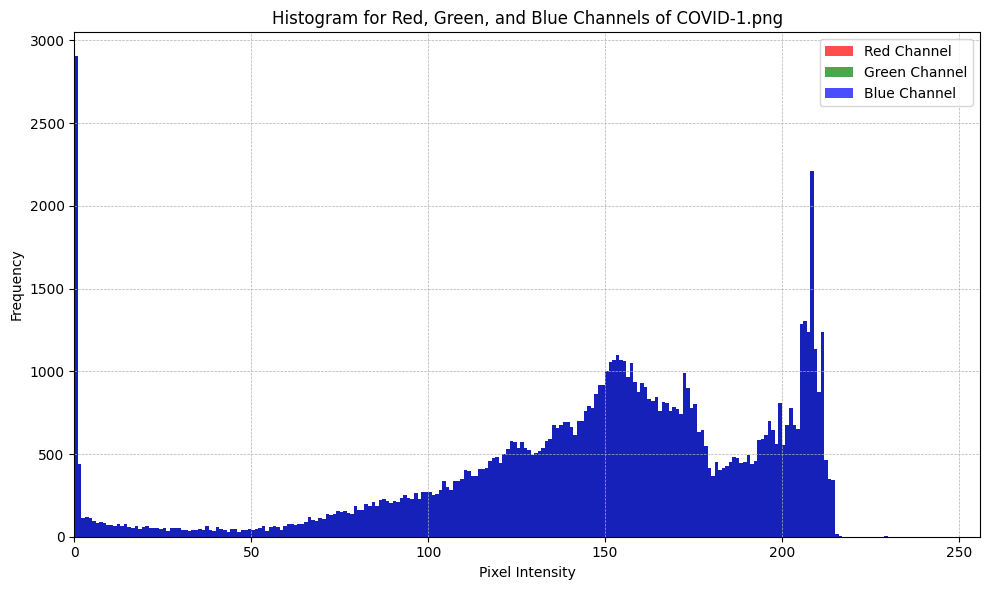

In [17]:
single_image_intensity_hist(file_path_1st_COVID, is_corrupted)

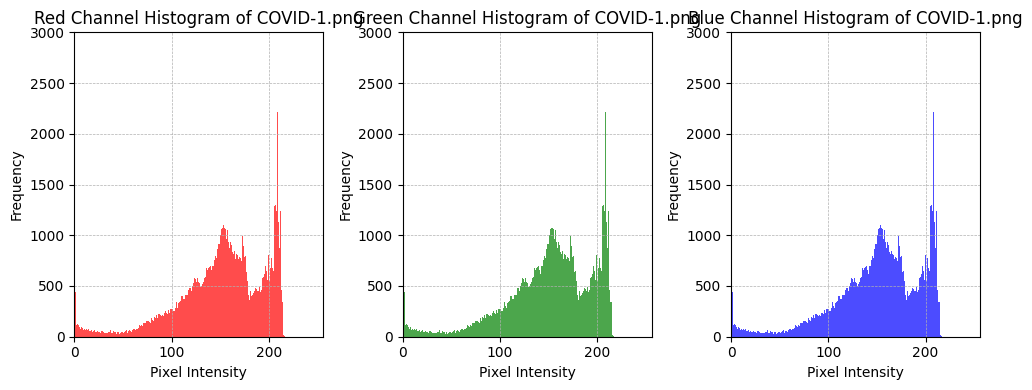

In [18]:
single_image_intensity_hist_2(file_path_1st_COVID, is_corrupted)

In [19]:
red_mean,red_skew, red_kurt,green_mean,green_skew, green_kurt,blue_mean,blue_skew, blue_kurt=single_image_intensity_statistic(file_path_1st_COVID,is_corrupted)

In [20]:
print(f"Red Channel - Avg_Intensity:{red_mean}, Skewness: {red_skew}, Kurtosis: {red_kurt}")
print(f"Green Channel - Avg_Intensity:{green_mean},Skewness: {green_skew}, Kurtosis: {green_kurt}")
print(f"Blue Channel - Avg_Intensity:{blue_mean},Skewness: {blue_skew}, Kurtosis: {blue_kurt}")

Red Channel - Avg_Intensity:145.89684679142292, Skewness: -1.1357669361301987, Kurtosis: 1.1000304290657894
Green Channel - Avg_Intensity:145.89684679142292,Skewness: -1.1357669361301987, Kurtosis: 1.1000304290657894
Blue Channel - Avg_Intensity:145.89684679142292,Skewness: -1.1357669361301987, Kurtosis: 1.1000304290657894


it is confirmed the statistic of intensity for different channels are all the same

##### 2.4.3.1.2 Single Image Check for NORMAL <a id='2.4.3.1.2_Single_Image_Check_for_NORMAL'></a>

In [21]:
#select first file in 'COVID' folder
file_path_1st_NORMAL=file_path('Normal',0)

In [22]:
#GET basic infor of first X-RAY image of COVID
image_formats,image_channels,height, width,avg_int,noise_std_dev,is_corrupted=single_image_basic(file_path_1st_NORMAL)
print(f"format:{image_formats}\n"
      f"Channels:{image_channels}\n"
      f"height,width:{height, width}\n"
      f"avg_intensity:{avg_int}\n"
      f"noise:{noise_std_dev}\n"
      f"Corrupted:{is_corrupted}")

format:PNG
Channels:3
height,width:(299, 299)
avg_intensity:85.1896958646995
noise:71.27003164623127
Corrupted:False


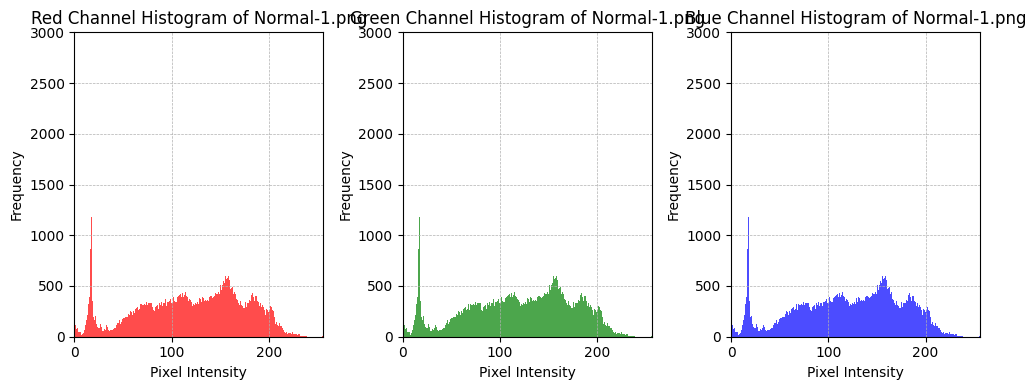

In [23]:
single_image_intensity_hist_2(file_path_1st_NORMAL, is_corrupted)

In [24]:
red_mean,red_skew, red_kurt,green_mean,green_skew, green_kurt,blue_mean,blue_skew, blue_kurt=single_image_intensity_statistic(file_path_1st_NORMAL,is_corrupted)

In [25]:
print(f"Red Channel - Avg_Intensity:{red_mean}, Skewness: {red_skew}, Kurtosis: {red_kurt}")
print(f"Green Channel - Avg_Intensity:{green_mean},Skewness: {green_skew}, Kurtosis: {green_kurt}")
print(f"Blue Channel - Avg_Intensity:{blue_mean},Skewness: {blue_skew}, Kurtosis: {blue_kurt}")

Red Channel - Avg_Intensity:85.1896958646995, Skewness: 0.0949184000560218, Kurtosis: -1.4268949160113358
Green Channel - Avg_Intensity:85.1896958646995,Skewness: 0.0949184000560218, Kurtosis: -1.4268949160113358
Blue Channel - Avg_Intensity:85.1896958646995,Skewness: 0.0949184000560218, Kurtosis: -1.4268949160113358


it is confirmed the statistic of intensity for different channels are all the same

##### 2.4.3.1.3 Single Image Check for VP <a id='2.4.3.1.3_Single_Image_Check_for_VP'></a>

In [26]:
#select first file in 'COVID' folder
file_path_1st_VP=file_path('Viral Pneumonia',0)

In [27]:
#GET basic infor of first X-RAY image of COVID
image_formats,image_channels,height, width,avg_int,noise_std_dev,is_corrupted=single_image_basic(file_path_1st_VP)
print(f"format:{image_formats}\n"
      f"Channels:{image_channels}\n"
      f"height,width:{height, width}\n"
      f"avg_intensity:{avg_int}\n"
      f"noise:{noise_std_dev}\n"
      f"Corrupted:{is_corrupted}")

format:PNG
Channels:3
height,width:(299, 299)
avg_intensity:121.50180646748917
noise:59.76496322212649
Corrupted:False


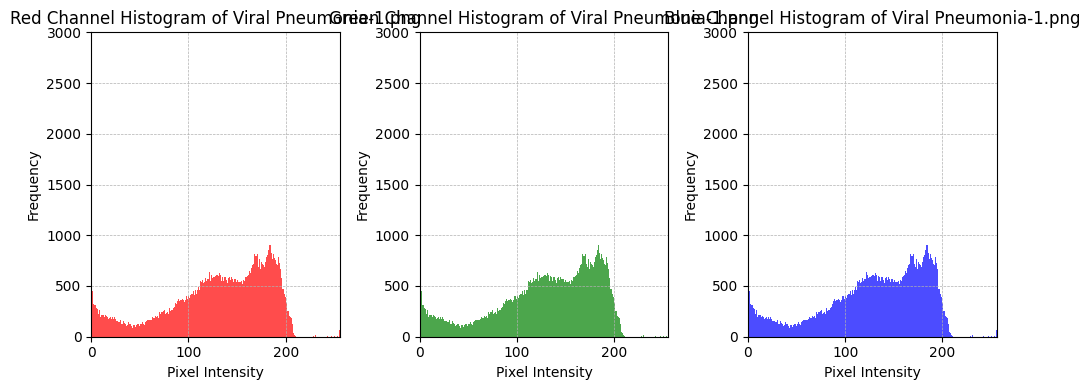

In [28]:
single_image_intensity_hist_2(file_path_1st_VP, is_corrupted)

In [29]:
red_mean,red_skew, red_kurt,green_mean,green_skew, green_kurt,blue_mean,blue_skew, blue_kurt=single_image_intensity_statistic(file_path_1st_VP,is_corrupted)

In [30]:
print(f"Red Channel - Avg_Intensity:{red_mean}, Skewness: {red_skew}, Kurtosis: {red_kurt}")
print(f"Green Channel - Avg_Intensity:{green_mean},Skewness: {green_skew}, Kurtosis: {green_kurt}")
print(f"Blue Channel - Avg_Intensity:{blue_mean},Skewness: {blue_skew}, Kurtosis: {blue_kurt}")

Red Channel - Avg_Intensity:121.50180646748917, Skewness: -0.7000648810286282, Kurtosis: -0.5568021310326468
Green Channel - Avg_Intensity:121.50180646748917,Skewness: -0.7000648810286282, Kurtosis: -0.5568021310326468
Blue Channel - Avg_Intensity:121.50180646748917,Skewness: -0.7000648810286282, Kurtosis: -0.5568021310326468


#### 2.4.3.2 Overall Image Consistency Check <a id='2.4.3.2_Overall_Image_Consistency_Check'></a>

In [31]:
def image_consistency_check(folder_path):
    filenames = []
    image_formats = []
    image_height = []
    image_width = []
    image_channels = []
    image_noise=[]
    image_mean=[]
    image_skewness=[]
    image_kurto=[]
    corrupted_images = []

    subfolders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]  
    first_subfolder = os.path.join(folder_path, subfolders[0])


    for filename in os.listdir(first_subfolder):
        file_path = os.path.join(first_subfolder, filename)
        file_extension = os.path.splitext(file_path)[1]
        # Check if the path is an actual file
        if os.path.isfile(file_path):
            is_corrupted = False
            try:
                img = cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
                 # Collect image formats, dimensions, and channels
                formats=file_extension[1:].upper()  # Assuming file format is the file extension   
                height, width = img.shape[:2] 
                if len(img.shape) == 2:
                    channels=1
                else:
                    channels=img.shape[2] 
                noise_std_dev = np.std(img)
                mean,skewness, kurto = intensity_statistics(img)
                #pass
            except Exception as e:
                print(f"Error processing {filename}. Reason: {e}")
            filenames.append(filename)
            image_formats.append(formats)
            image_height.append(height)
            image_width.append(width)
            image_noise.append(noise_std_dev)
            image_mean.append(mean)
            image_skewness.append(skewness)
            image_kurto.append(kurto)
            image_channels.append(channels)
            corrupted_images.append(is_corrupted)
            # Convert the lists to a dataframe

    df = pd.DataFrame({
    'Filename': filenames,
    'Format': image_formats,
    'height': image_height,
    'width':image_width,
    'noise':image_noise,
    'mean_intensity':image_mean,
    'skewness':image_skewness,
    'kurto':image_kurto,
    'Channels': image_channels,
    'Corrupted': corrupted_images
    })

    return df


In [32]:
def categorical_col_check(df):
    # List of columns for which you want to perform value_counts
    cols_to_check = ['Format', 'Corrupted']

    # Create a list of value_counts Series for each column
    value_counts_list = [df[col].value_counts() for col in cols_to_check]

    # Concatenate them to create a new dataframe
    value_counts_df = pd.concat(value_counts_list, axis=1, keys=cols_to_check)

    # Handle NaN (if some categories appear in one column but not in others)
    value_counts_df.fillna(0, inplace=True)

    return value_counts_df

In [33]:
df_COVID=image_consistency_check('COVID')

In [34]:
df_COVID

,Filename,Format,height,width,noise,mean_intensity,skewness,kurto,Channels,Corrupted
0,COVID-1.png,PNG,299,299,51.816632,145.896847,-1.135767,1.100030,1,False
1,COVID-10.png,PNG,299,299,40.623291,141.355466,0.015495,-0.398089,1,False
2,COVID-100.png,PNG,299,299,73.778044,152.878570,-0.648836,-0.586259,1,False
3,COVID-1000.png,PNG,299,299,76.249129,162.771054,-0.899669,-0.383799,1,False
4,COVID-1001.png,PNG,299,299,66.179559,129.890784,-0.908403,-0.459331,1,False
...,...,...,...,...,...,...,...,...,...,...
3611,COVID-995.png,PNG,299,299,44.142674,146.749790,-1.469263,2.271402,1,False
3612,COVID-996.png,PNG,299,299,44.487178,141.034351,-0.178504,-0.298645,1,False
3613,COVID-997.png,PNG,299,299,61.498515,119.462948,-0.319287,-0.584525,1,False
3614,COVID-998.png,PNG,299,299,64.311230,134.761949,-0.998925,-0.169866,1,False


In [35]:
df_COVID.describe()

,height,width,noise,mean_intensity,skewness,kurto,Channels
count,3616.0,3616.0,3616.000000,3616.000000,3616.000000,3616.000000,3616.0
mean,299.0,299.0,54.647365,139.521210,-0.567142,-0.154937,1.0
std,0.0,0.0,14.829089,25.029784,0.410506,1.053277,0.0
min,299.0,299.0,14.145251,25.511381,-3.320548,-1.817289,1.0
25%,299.0,299.0,45.049010,126.883094,-0.823584,-0.774913,1.0
50%,299.0,299.0,54.045331,142.594753,-0.559246,-0.432860,1.0
75%,299.0,299.0,63.411343,155.970733,-0.324580,0.219372,1.0
max,299.0,299.0,106.998675,216.561839,2.672366,28.404155,1.0


In [36]:
categorical_col_check(df_COVID)

,Format,Corrupted
PNG,3616.0,0.0
False,0.0,3616.0


In [37]:
df_Normal=image_consistency_check('Normal')

In [38]:
df_Normal.describe()

,height,width,noise,mean_intensity,skewness,kurto,Channels
count,10192.0,10192.0,10192.000000,10192.000000,10192.000000,10192.000000,10192.0
mean,299.0,299.0,61.559355,129.389800,-0.402216,-0.544414,1.0
std,0.0,0.0,9.551679,22.448670,0.425781,0.800513,0.0
min,299.0,299.0,19.176520,26.443597,-1.997278,-1.673526,1.0
25%,299.0,299.0,56.011971,113.520593,-0.692116,-1.083187,1.0
50%,299.0,299.0,63.533669,125.509709,-0.328769,-0.871859,1.0
75%,299.0,299.0,68.436316,143.643505,-0.084022,-0.262124,1.0
max,299.0,299.0,98.862049,201.849543,1.666765,4.909505,1.0


In [39]:
categorical_col_check(df_Normal)

,Format,Corrupted
PNG,10192.0,0.0
False,0.0,10192.0


In [40]:
df_VP=image_consistency_check('Viral Pneumonia')

In [41]:
df_VP.describe()

,height,width,noise,mean_intensity,skewness,kurto,Channels
count,1345.0,1345.0,1345.000000,1345.000000,1345.000000,1345.000000,1345.0
mean,299.0,299.0,58.745215,125.369630,-0.654826,-0.441470,1.0
std,0.0,0.0,10.778896,18.980974,0.413307,0.925560,0.0
min,299.0,299.0,24.163092,64.772698,-2.720895,-1.608779,1.0
25%,299.0,299.0,51.265395,113.497880,-0.857564,-0.978747,1.0
50%,299.0,299.0,59.706783,126.860013,-0.658680,-0.657773,1.0
75%,299.0,299.0,66.914915,137.787776,-0.445487,-0.232203,1.0
max,299.0,299.0,87.315388,193.691961,0.904093,8.346179,1.0


In [42]:
categorical_col_check(df_VP)

,Format,Corrupted
PNG,1345.0,0.0
False,0.0,1345.0


In [43]:
df_Lopacity=image_consistency_check('Lung_Opacity')

In [44]:
df_Lopacity.describe()

,height,width,noise,mean_intensity,skewness,kurto,Channels
count,6012.0,6012.0,6012.000000,6012.000000,6012.000000,6012.000000,6012.0
mean,299.0,299.0,57.397085,126.021596,-0.475563,-0.274091,1.0
std,0.0,0.0,9.807737,23.570601,0.462459,0.958932,0.0
min,299.0,299.0,26.788407,32.226899,-3.000745,-1.774280,1.0
25%,299.0,299.0,50.429886,110.578643,-0.750409,-0.913424,1.0
50%,299.0,299.0,56.967917,120.819543,-0.405607,-0.522136,1.0
75%,299.0,299.0,64.261198,142.098830,-0.169242,0.034705,1.0
max,299.0,299.0,93.454276,229.141676,1.384773,10.998084,1.0


In [45]:
categorical_col_check(df_Lopacity)

,Format,Corrupted
PNG,6012.0,0.0
False,0.0,6012.0


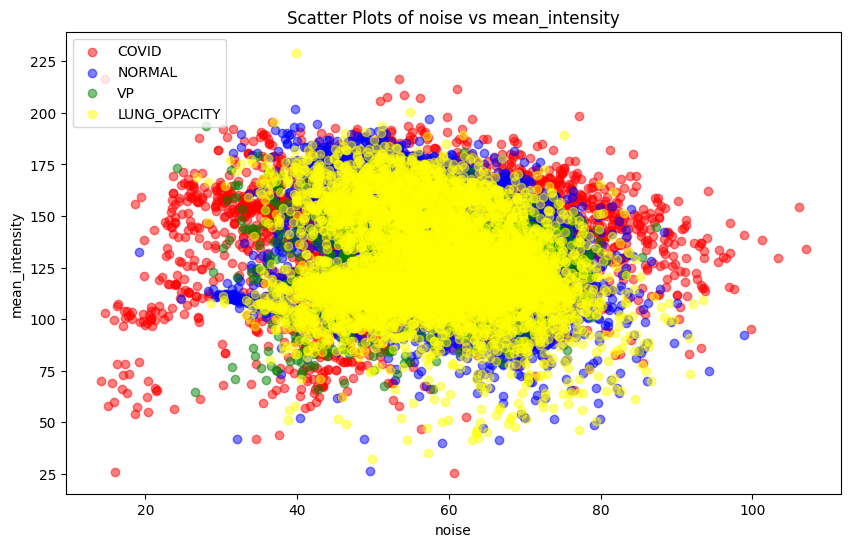

In [46]:
plt.figure(figsize=(10, 6))

# Plotting for df1
plt.scatter(df_COVID['noise'], df_COVID['mean_intensity'], color='red', label='COVID', alpha=0.5)

# Plotting for df2
plt.scatter(df_Normal['noise'], df_Normal['mean_intensity'], color='blue', label='NORMAL', alpha=0.5)

# Plotting for df3
plt.scatter(df_VP['noise'], df_VP['mean_intensity'], color='green', label='VP', alpha=0.5)

# Plotting for df4
plt.scatter(df_Lopacity['noise'], df_Lopacity['mean_intensity'], color='yellow', label='LUNG_OPACITY', alpha=0.5)


# Setting labels, title and legend
plt.xlabel('noise')
plt.ylabel('mean_intensity')
plt.title('Scatter Plots of noise vs mean_intensity')
plt.legend(loc='upper left')

# Display the plot
plt.show()

## 2.5 Summary

1. Datasets Overview

    1) there are four folders containing images with different category: Normal, COVID, Viral Pneumonia,Lung_Opacity

    2) 3616 images for COVID 10192 images for normal 6012 images for Lung_Opacity, 1345 for Viral Pneumonia
    
    3) Image are colored image, but intensity distribution is exact same along all three channels, theresore grey image is used for further analysis

2. Image consistency check   

    1) Image are all in same size ,resolution, 
    
    2) for different categories, the image parameter are in different range e.g avg_intensity for normal case 129+-22, for COVID 140+/-25, VP 125+/-19, normalization may be needed for image preprocessing
    
    3) varying levels of noise across images, noise reduction technique may be needed like guassian blurring
    
    4) image augmentation
    
    5) ROI selection?
    

3. feature extraction
    1) statistical features like intensity mean, standard deviation, skewness, and kurtosis from the pixel intensity distributions.
 
    2) Shape and Contour Features: Hough Transform for detecting shapes in the X-ray which might be indicative of particular conditions.
    
    3) texture/orientation features: Gabor Filters
    
    4) deep learning CNNs
  
4. sample imbalance
   1) number in different cases are largely different, data imbalance might be a concern
    